## IDS576 - Team 3
#### Training CIFAR with Dropout as common approach to combat adversary samples

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
%config IPCompleter.greedy = True
random_seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
import numpy as np
def get_train_data_stats(train_data):
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array\
    x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
    print(x.shape)
    # calculate the mean and std along the (0, 1) axes
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(train_mean, train_std)
    return train_mean, train_std

In [5]:
# load the training data for determination of mean and std
data_path = '~/IDS576/data'
train_data = datasets.CIFAR10(root=data_path, train=True, download=True)
train_mean, train_std = get_train_data_stats(train_data)
print(train_mean/255, train_std/255)

Files already downloaded and verified
(1600000, 32, 3)
[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [6]:
normalize = transforms.Normalize(
    mean=train_mean/255,
    std=train_std/255)

train_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])
    
val_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])

In [7]:
# Download train and test data
data_path = '~/IDS576/data'
trainset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_transform)
valset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=val_transform)
testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Split train data in to train and validation data using torch dataset and utils.data modules

val_size = .2
n_train = len(trainset)

# get train set indices and split point based on val size
indices = list(range(n_train))
split = int(np.floor(val_size * n_train))

# shuffle trainset indices
np.random.seed(random_seed)
np.random.shuffle(indices)

# split train into train and val with shuffled indices at split point. 
train_idx, val_idx = indices[split:], indices[:split]

# Create train and val samplers based in split indices for use with DataLoader batch sampling
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

batch_size = 128 # per paper
n_trn = n_train*(1-val_size)
batches = n_trn/batch_size

# CUDA settings
num_workers = 0 # allows preload of next batch, but greater than zero isn't recommended for cuda ops
pin_memory = True

train_dl = DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

val_dl = DataLoader(
    valset, batch_size=batch_size, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

test_dl = DataLoader(
    testset, batch_size=batch_size,
    num_workers=num_workers, pin_memory=pin_memory)

def single_dl(xy, batch_size=1):
    return DataLoader(xy, batch_size=batch_size, num_workers=1, pin_memory=pin_memory)

In [9]:
classes = trainset.classes
classdict = {label: name for label, name in enumerate(classes)}
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    correct = 0
    output = model(xb)
    _, preds = torch.max(output, 1)
    correct = torch.sum(preds == yb)
    acc = correct.double()/len(yb)
    loss = loss_func(output, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), acc   

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    mod = n_trn/(batch_size*20)
    running_corrects = 0
    val_accs = []
    val_losses = []
    for epoch in range(epochs):
        since = time.time()
        model.train()
        #i=0
        print(f'Epoch {epoch+1}/{epochs}: [', end='')
        for i, (xb, yb) in enumerate(train_dl):
            if not i % mod:
                print('*', end='')
            loss_batch(model, loss_func, xb, yb, opt)
            #i+=1
        print(']', end='')
        model.eval()
        print(' Val Loss: ', end='')
        with torch.no_grad():
            losses, nums, acc = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(acc, nums)) / np.sum(nums)
        
        # Save history
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'{val_loss:6.4f}, Val Acc: {val_acc:6.4f} ', end='')
        until = time.time()
        print(f'Elapsed (sec): {until-since:<5.1f}')
    return val_accs, val_losses

In [ ]:
class CIFAR_Standard(nn.Module):
    
    def __init__(self):
        super(CIFAR_Standard, self).__init__()
        self.conv1a = nn.Conv2d(3, 64, 3, padding=2)
        self.conv1b = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2a = nn.Conv2d(64, 72, 3, padding=1)
        self.conv2b = nn.Conv2d(72, 72, 3, padding=1)
        self.fc1 = nn.Linear(72 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
                             
    def forward(self, x):
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2a(x)
        x = self.conv2b(x)
        
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 72 * 8 * 8) 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return x

In [15]:
class CIFAR_Dropout(nn.Module):
    
    def __init__(self):
        super(CIFAR_Dropout, self).__init__()
        self.conv1a = nn.Conv2d(3, 64, 3, padding=2)
        self.conv1b = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2a = nn.Conv2d(64, 72, 3, padding=1)
        self.conv2b = nn.Conv2d(72, 72, 3, padding=1)
        self.fc1 = nn.Linear(72 * 8 * 8, 512)
        self.dropout = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
                             
    def forward(self, x):
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2a(x)
        x = self.conv2b(x)
        
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 72 * 8 * 8) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x


In [16]:
import torch.nn as nn
import torch
import numpy as np

class RFN(nn.Module):
    '''Wrapper class that takes any nn.Module based model and adds an RFN layer prior to all other layers.'''
    
    
    def __init__(self, model, mu=.1, sigma=.05, rfn_flag=True):
        super(RFN, self).__init__()
        self.model = model
        self.mu = mu
        self.sigma = sigma
        self.rfn_flag = rfn_flag
        self.shape_vals = None

    def forward(self, x):
        if self.rfn_flag:
            x = self.random_masks(x) * x
            x = self.model(x)
        else:
            x = self.model(x)
        return x
    
    
    def random_masks(self, x):
        # Calculate shape values for x
        self.shape_vals = x.size(), x[0].size(), x[0].nelement()

        # Create ones array of size (batch,channel,horiz,vert)
        masks = np.ones(self.shape_vals[0])

        # Create random masks for each sample in the batch
        for mask in masks:
            zero_cnt = np.absolute(int(np.ceil((self.sigma * np.random.randn() + self.mu) * self.shape_vals[2])))
            zero_idx = np.random.choice(self.shape_vals[2], zero_cnt, replace=False)
            mask.reshape(self.shape_vals[2])[zero_idx] = 0
            mask.reshape(self.shape_vals[1])
        return torch.tensor(masks, dtype=torch.float, device=device)

In [17]:
from collections import defaultdict
# Create history dict for all models with validation accuracy and loss per epoch
history = defaultdict(list)

In [18]:
# Train Standard CIFAR model using paper hyperparams

#rfn_mu_vals = [0,.1, 0, .2, .3, .4, .5]
rfn_mu_vals = [0]
epochs = 50

for mu in rfn_mu_vals:    
    # Set whether RFN will be used in training
    if mu == 0:
        rfn_flag = False
    else:
        rfn_flag = True
        
    print(f'Training RFN: {rfn_flag}, mu={mu}:')     
    cifar_rfn = CIFAR_Dropout()
    cifar_rfn.to(device)
    rfn_wrapper = RFN(cifar_rfn, mu=mu, sigma=.05, rfn_flag=rfn_flag)
    rfn_wrapper.to(device)
    
    loss_func = nn.CrossEntropyLoss()
    opt = optim.Adam(cifar_rfn.parameters(), lr=0.001)
    
    history[mu] = fit(epochs, rfn_wrapper, loss_func, opt, train_dl, val_dl)
    
    # Save model
    PATH = f'./models/CIFAR_Dropout.pth'
    torch.save(cifar_rfn.state_dict(), PATH)

Training RFN: False, mu=0:
Epoch 1/50: [***] Val Loss: 1.5133, Val Acc: 0.5071 Elapsed (sec): 19.6 
Epoch 2/50: [***] Val Loss: 1.2509, Val Acc: 0.5894 Elapsed (sec): 12.6 
Epoch 3/50: [***] Val Loss: 1.1558, Val Acc: 0.6250 Elapsed (sec): 11.8 
Epoch 4/50: [***] Val Loss: 1.1076, Val Acc: 0.6334 Elapsed (sec): 11.7 
Epoch 5/50: [***] Val Loss: 1.0798, Val Acc: 0.6418 Elapsed (sec): 11.6 
Epoch 6/50: [***] Val Loss: 1.0752, Val Acc: 0.6506 Elapsed (sec): 11.8 
Epoch 7/50: [***] Val Loss: 1.0784, Val Acc: 0.6485 Elapsed (sec): 11.7 
Epoch 8/50: [***] Val Loss: 0.9714, Val Acc: 0.6783 Elapsed (sec): 11.9 
Epoch 9/50: [***] Val Loss: 0.9603, Val Acc: 0.6867 Elapsed (sec): 11.7 
Epoch 10/50: [***] Val Loss: 0.7637, Val Acc: 0.7632 Elapsed (sec): 11.7 
Epoch 11/50: [***] Val Loss: 0.7818, Val Acc: 0.7534 Elapsed (sec): 11.7 
Epoch 12/50: [***] Val Loss: 0.8401, Val Acc: 0.7616 Elapsed (sec): 11.8 
Epoch 13/50: [***] Val Loss: 0.8745, Val Acc: 0.7546 Elapsed (sec): 11.7 
Epoch 14/50: [***] V

In [34]:
import pickle
with open('./models/cifar_history_dropout.pkl', 'wb') as f:
    pickle.dump(history, f)

In [35]:
with open('./models/cifar_history_dropout.pkl', 'rb') as f:
    history = pickle.load(f)

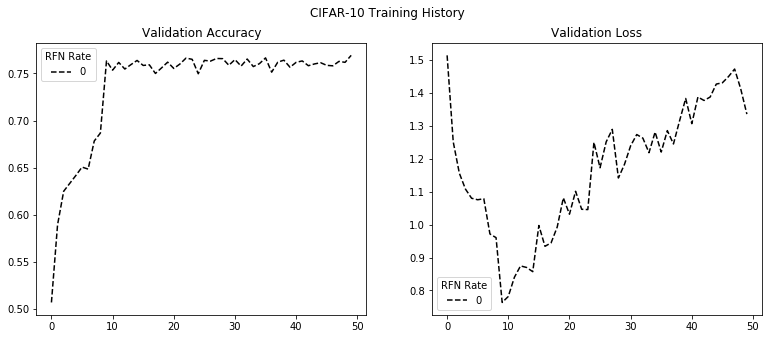

In [36]:
import matplotlib.pyplot as plt

colors = ['k', 'r', 'b', 'g', 'm', 'c']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
fig.suptitle('CIFAR-10 Training History')
ax[0].set_title('Validation Accuracy')
ax[1].set_title('Validation Loss')
for c, (k, v) in zip(colors, history.items()):
    ax[0].plot(range(len(v[0])), v[0], c+'--', label=str(k))
    ax[1].plot(range(len(v[1])), v[1], c+'--', label=str(k))
ax[0].legend(title='RFN Rate')
ax[1].legend(title='RFN Rate')

In [27]:
def fgsm_batch(net, orig, eps=15):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.float().clone().detach().to(device).requires_grad_(True)
    
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = torch.argmax(prior_out)
    
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    loss = criterion(prior_out, prior_pred.unsqueeze(0))
    loss.backward()
    
    # Actual FSGM method
    #print(orig.min(), orig.max())
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    '''
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig'''
    
    return inp

In [28]:
def evaluate(net, dataloader, eps=15, adv=False):
    correct = 0
    count = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if adv:
            inputs = fgsm_batch(net, inputs, eps = eps)
        preds = net(inputs)
        if torch.argmax(preds) == labels:
            correct += 1.0
        count += 1.0
        if not i % 5000:
            print(f'Sample: {i}, Running Accuracy: {(correct/count):5.3f}')
    acc = correct/count
    print(f'Accuracy over {int(count)} samples: {acc:5.3f}')
    return acc

In [37]:
# Create accuracy dictionary
from collections import defaultdict
accs_no_fsgm = defaultdict(list)
accs_fsgm = defaultdict(list)

models = ['Standard', 'Dropout', 'RFN']
rfn_mu_vals = [0]
epsilons = [0, 40, 60, 90]

analysis = {}
for model in models:
    analysis[model] = {}
    for adv in [True, False]:
        analysis[model][adv] = {}
        for mu in rfn_mu_vals:
            analysis[model][adv][mu] = {}
            for eps in epsilons:
                analysis[model][adv][mu][eps] = []

In [42]:
# load CIFAR models
val_dl = DataLoader(
    valset, batch_size=1, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

rfn_mu_vals = [0]
epsilons = [40, 60, 90]
models = ['Standard': CIFAR_Standard(), 'Dropout': CIFAR_Dropout()]

# Evaluate pretrained CIFAR CNNs with and without FSGM attack, set sigma on RFN = 0 
for model_name, model_instance in models.items():
    for eps in epsilons:
        for adv in [False, True]:
            for i, mu in enumerate(rfn_mu_vals):
                model = CIFAR_Dropout()
                rfn_wrapper = RFN(model, mu=mu, sigma=0, rfn_flag=True)
                model.load_state_dict(torch.load(f'./models/CIFAR_{model}.pth'))
                model.to(device)
                model.eval()
                criterion = nn.CrossEntropyLoss()
                if adv:
                    print(f'Evaluate CIFAR {model} at epsilon={eps}, mu={mu}:')
                    analysis[model][adv][mu][eps] = evaluate(rfn_wrapper, val_dl, eps=eps, adv=adv)
                else:
                    print(f'Evaluate CIFAR {model} without FSGM, mu={mu}:')
                    analysis[model][adv][mu][0] = evaluate(rfn_wrapper, val_dl, eps=eps, adv=adv)

Evaluate CIFAR Dropout without FSGM, mu=0:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.768
Accuracy over 10000 samples: 0.769
Evaluate CIFAR Dropout at epsilon=0, mu=0:
Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.770
Accuracy over 10000 samples: 0.769
Evaluate CIFAR Dropout without FSGM, mu=0:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.774
Accuracy over 10000 samples: 0.769
Evaluate CIFAR Dropout at epsilon=40, mu=0:
Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.319
Accuracy over 10000 samples: 0.316
Evaluate CIFAR Dropout without FSGM, mu=0:
Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.766
Accuracy over 10000 samples: 0.769
Evaluate CIFAR Dropout at epsilon=60, mu=0:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.277
Accuracy over 10000 samples: 0.269
Evaluate CIFAR Dropout without FSGM, mu=0:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, 

In [79]:
print('\t\tFSGM Epsilons:')
print(f'MU\tModel\t{0:>9}{40:>10}{60:>10}{90:>10}')
for mu in rfn_mu_vals:
    print(f'{mu}\t{model}\
    {analysis[model][False][mu][0]:.4}\
    {analysis[model][True][mu][40]:.4}\
    {analysis[model][True][mu][60]:.4}\
    {analysis[model][True][mu][90]:.4}')

		FSGM Epsilons:
MU	Model	        0        40        60        90
0	Dropout    0.7691    0.3162    0.2687    0.2172


In [41]:
analysis[model][False][mu].keys()

dict_keys([0, 40, 60, 90])